[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dgomes03/FIRE-HACK-Project/blob/main/RFR_model.ipynb)

In [29]:
import os
import math
import warnings
import numpy as np
import pandas as pd
import geopandas as gpd
from dbfread import DBF
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy import stats
from scipy.stats import randint, uniform, gaussian_kde
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    TimeSeriesSplit,
    KFold,
    HalvingRandomSearchCV,
)
from sklearn.experimental import enable_halving_search_cv 
from sklearn.inspection import PartialDependenceDisplay
import xgboost as xgb
import shap
import pickle
import shap

### Load data

In [30]:
print("Loading dataset...")

try:
    shp_path = '../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp'
    df = gpd.read_file(shp_path)
    print("Dataset loaded")

except Exception as e:
    print(f"Error loading dataset: {e}")
    raise

Loading dataset...
Dataset loaded


In [31]:
df['row_id'] = range(len(df))

### Remove nans from ros_p

In [32]:
n_before = len(df)
df = df.dropna(subset=['ros_p'])
n_after = len(df)
print(f"Removed {n_before - n_after} rows with NaN in 'ros_p'. Remaining rows: {n_after}")

Removed 4 rows with NaN in 'ros_p'. Remaining rows: 1173


### Convert categorical variables into "category" type

In [33]:
c = ["fuel_model", "landform", "land_use", "Haines_av"]

for col in c:
     df[col] = df[col].astype(str).astype('category')

### Turn ros lags into log

In [34]:
log_mult = 5
log_base = 10

lags = [col for col in df.columns if col.startswith('ros_p_lg')]

for col in lags:
    log_col = f'{col}_log'
    df[log_col] = np.where(
        df[col] > 0,
        log_mult * np.log1p(df[col]) / np.log(log_base),
        np.nan
    )

df.drop(columns=lags, inplace=True)

### Select specific columns for modeling
These variables were chosen because they have the highest |SHAP| values, being considered the most important for modeling.

In [35]:
df.drop(columns=['ros_p_lg1_log'], inplace=True)

In [36]:
c = [
    "duration_p",
    "3_8y_fir_p",
    "wv100_k_av",
    "f_load_av",
    "FWI_12h_av",
    "rh_2m_av",
    "8_ny_fir_p",
    "f_start",
    "wdi_950_av",
    "row_id",
    "ros_p"
]

df = df[c]

### Features with highest sum of correlation

In [37]:
num_df = df.select_dtypes(include=["number"])

corr_matrix = num_df.corr()

corr_sum = corr_matrix.abs().sum()

corr_sum = corr_sum.sort_values(ascending=False, kind="mergesort")

print(corr_sum)

"""# change number to change n of top vars to drop
drop = corr_sum.index[:5].tolist()

print("\nVariables removed:")
print(drop)

df = df.drop(columns=drop)"""

FWI_12h_av    2.765532
wv100_k_av    2.598022
ros_p         2.558303
8_ny_fir_p    2.467065
duration_p    2.380289
f_load_av     2.278074
f_start       2.212508
rh_2m_av      2.177040
3_8y_fir_p    2.135373
wdi_950_av    1.940768
row_id        1.544484
dtype: float64


'# change number to change n of top vars to drop\ndrop = corr_sum.index[:5].tolist()\n\nprint("\nVariables removed:")\nprint(drop)\n\ndf = df.drop(columns=drop)'

### Create test and train datasets

In [38]:
train_features = [col for col in df.columns if col not in ('ros_p', 'inidoy', 'enddoy', "geometry", 'row_id')]

X = df[train_features + ['row_id']]
y = df['ros_p']

# validation split (the validation dataset will not be used until final model evaluation)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

### XGBoost Model
This model first uses a KFold approach for Cross-Validation in order to find the best hyperparameters for the XGBoost model. Then, it applies these hyperparameters to train the final model which is trained on 100% of the dataset The "Best Cross-Validation Score (R2)" score given is the average R2 of the Cross Validation process, not the R2 from the final model, since there is not test dataset.

In [39]:
param_dist = {
    'max_depth': [3, 4, 5],                           # ← Increased from [2, 3, 4]
    'learning_rate': uniform(0.05, 0.20),             # ← Slightly lower floor (0.05-0.25)
    'subsample': uniform(0.55, 0.25),                 # ← Wider range (0.55-0.80)
    'colsample_bytree': uniform(0.55, 0.25),          
    'colsample_bylevel': uniform(0.55, 0.25),          
    'colsample_bynode': uniform(0.55, 0.25),          
    'min_child_weight': randint(30, 80),              # ← Reduced from (50, 100)
    'gamma': uniform(1.5, 2.5),                       # ← Reduced from (3, 3) → 1.5-4.0
    'reg_alpha': uniform(1.0, 2.5),                   # ← Reduced from (2, 3) → 1.0-3.5
    'reg_lambda': uniform(3, 4),                      # ← Reduced from (6, 4) → 3-7
    'max_delta_step': randint(0, 5),
}

base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,
    resource='n_estimators',
    max_resources=250,                               # ← Increased from 200
    min_resources=25,                                # ← Slight increase
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    return_train_score=True, 
    verbose=1
)

In [40]:
"""
We apply a log transformation to the target variable 'y' using the formula below.
The parameters can be tweeked if needed. The default is set to a multiplier of 5 and base 10
which give slightly better results.
"""
log_mult = 5
log_base = 10

y_train_log = log_mult *  np.log1p(y_train) / np.log(log_base)

xgb_random.fit(
    X_train[train_features], 
    y_train_log
)

print("\nBest Cross-Validation Score (R2):", xgb_random.best_score_)
print("Mean train score:", xgb_random.cv_results_['mean_train_score'])
print("Mean test score:", xgb_random.cv_results_['mean_test_score'])

final_model = xgb_random.best_estimator_

final_model.save_model("../../Data/Models/XGBoost.json")
print("Best model saved.")

# final_model is your trained estimator
with open("../../Data/Models/XGBoost.pkl", "wb") as f:
    pickle.dump(final_model, f)

print("Model pickled successfully!")

n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 25
max_resources_: 250
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 10
n_resources: 25
Fitting 5 folds for each of 10 candidates, totalling 50 fits


----------
iter: 1
n_candidates: 4
n_resources: 75
Fitting 5 folds for each of 4 candidates, totalling 20 fits
----------
iter: 2
n_candidates: 2
n_resources: 225
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best Cross-Validation Score (R2): 0.5649912585285612
Mean train score: [0.48507676 0.35156646 0.59109751 0.34714188 0.44977607 0.48324041
 0.51168285 0.59402987 0.55030948 0.36720131 0.63327847 0.65487473
 0.71761617 0.6727795  0.71572506 0.78609264]
Mean test score: [0.41315442 0.31556702 0.49769967 0.30331656 0.38524384 0.42091606
 0.44897588 0.51462217 0.46125269 0.31562502 0.5295602  0.53315787
 0.5538201  0.54699374 0.54946696 0.56499126]
Best model saved.
Model pickled successfully!



=== FINAL MODEL VALIDATION RESULTS ===
Train R² (log): 0.7958
Val R² (log):   0.5618
Overfitting Gap: 0.2340
RMSE (log): 1.4750 (linear: 758.1)
MAE (log): 1.1519 (linear: 436.5)


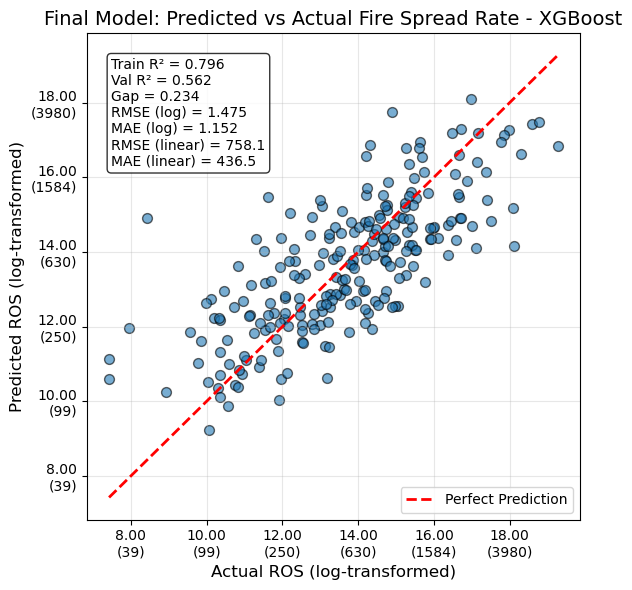

In [41]:
# Evaluate on validation set
y_val_log = log_mult * np.log1p(y_val) / np.log(log_base)
y_val_pred_log = final_model.predict(X_val[train_features])

# Keep log space values for plotting
y_val_log_space = y_val_log.copy()
y_val_pred_log_space = y_val_pred_log.copy()

# Inverse transform log to linear for linear metrics
inv_mult = np.log(log_base) / log_mult
y_val_linear = np.exp(y_val_log * inv_mult) - 1
y_val_pred_linear = np.exp(y_val_pred_log * inv_mult) - 1

# Metrics in log space
r2_val = r2_score(y_val_log_space, y_val_pred_log_space)
rmse_log_val = np.sqrt(mean_squared_error(y_val_log_space, y_val_pred_log_space))
mae_log_val = mean_absolute_error(y_val_log_space, y_val_pred_log_space)

# Metrics in linear space
rmse_linear_val = np.sqrt(mean_squared_error(y_val_linear, y_val_pred_linear))
mae_linear_val = mean_absolute_error(y_val_linear, y_val_pred_linear)

# Train metrics for overfitting check
y_train_pred_log = final_model.predict(X_train[train_features])
r2_train = r2_score(y_train_log, y_train_pred_log)

print("\n=== FINAL MODEL VALIDATION RESULTS ===")
print(f"Train R² (log): {r2_train:.4f}")
print(f"Val R² (log):   {r2_val:.4f}")
print(f"Overfitting Gap: {r2_train - r2_val:.4f}")
print(f"RMSE (log): {rmse_log_val:.4f} (linear: {rmse_linear_val:.1f})")
print(f"MAE (log): {mae_log_val:.4f} (linear: {mae_linear_val:.1f})")

# Predicted vs Actual scatter plot IN LOG SPACE
plt.figure(figsize=(6, 6))
plt.scatter(y_val_log_space, y_val_pred_log_space, alpha=0.6, edgecolor='k', s=50)

# Perfect prediction line
min_val = min(y_val_log_space.min(), y_val_pred_log_space.min())
max_val = max(y_val_log_space.max(), y_val_pred_log_space.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

plt.title('Final Model: Predicted vs Actual Fire Spread Rate - XGBoost', fontsize=14)
plt.xlabel('Actual ROS (log-transformed)', fontsize=12)
plt.ylabel('Predicted ROS (log-transformed)', fontsize=12)

# Add metrics annotation
plt.text(0.05, 0.95, 
    f'Train R² = {r2_train:.3f}\n'
    f'Val R² = {r2_val:.3f}\n'
    f'Gap = {r2_train - r2_val:.3f}\n'
    f'RMSE (log) = {rmse_log_val:.3f}\n'
    f'MAE (log) = {mae_log_val:.3f}\n'
    f'RMSE (linear) = {rmse_linear_val:.1f}\n'
    f'MAE (linear) = {mae_linear_val:.1f}', 
    transform=plt.gca().transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Tick formatter to show both log and linear values
def tick_formatter_log_to_linear(x, pos):
    linear_val = np.exp(x * inv_mult) - 1
    return f"{x:.2f}\n({linear_val:.0f})"

ax = plt.gca()
ax.xaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))
ax.yaxis.set_major_formatter(plt.FuncFormatter(tick_formatter_log_to_linear))

plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

NOTE: The saved model will make predictions in Log space since it was trained in that space. To see outputs in linear space, a conversion needs to be perfomed after running the model. The code below stores the Log transformation applied so that it can be reversed in the future.

In [42]:
import json
transform_params = {
    'log_mult': log_mult, 
    'log_base': log_base,
    'inverse_formula': 'y_val_log = np.exp(y_val_pred_log * np.log(log_base) / log_mult) - 1'
}
with open('../../Data/Models/XGBoost_transform_param.json', 'w') as f:
    json.dump(transform_params, f)

This file would then be used as follows:
```python
# Load the model
loaded_model = xgb.XGBRegressor()
loaded_model.load_model("../../Data/Models/XGBoost.json")

# Load the transformation parameters
with open('../../Data/Models/XGBoost_transform.json', 'r') as f:
    transform_params = json.load(f)

# Make predictions in log space
y_val_pred_log = loaded_model.predict(X_new)

# Inverse transform using the saved parameters
log_mult = transform_params['log_mult']
log_base = transform_params['log_base']

y_val_pred_log = np.exp(y_val_pred_log * np.log(log_base) / log_mult) - 1
```

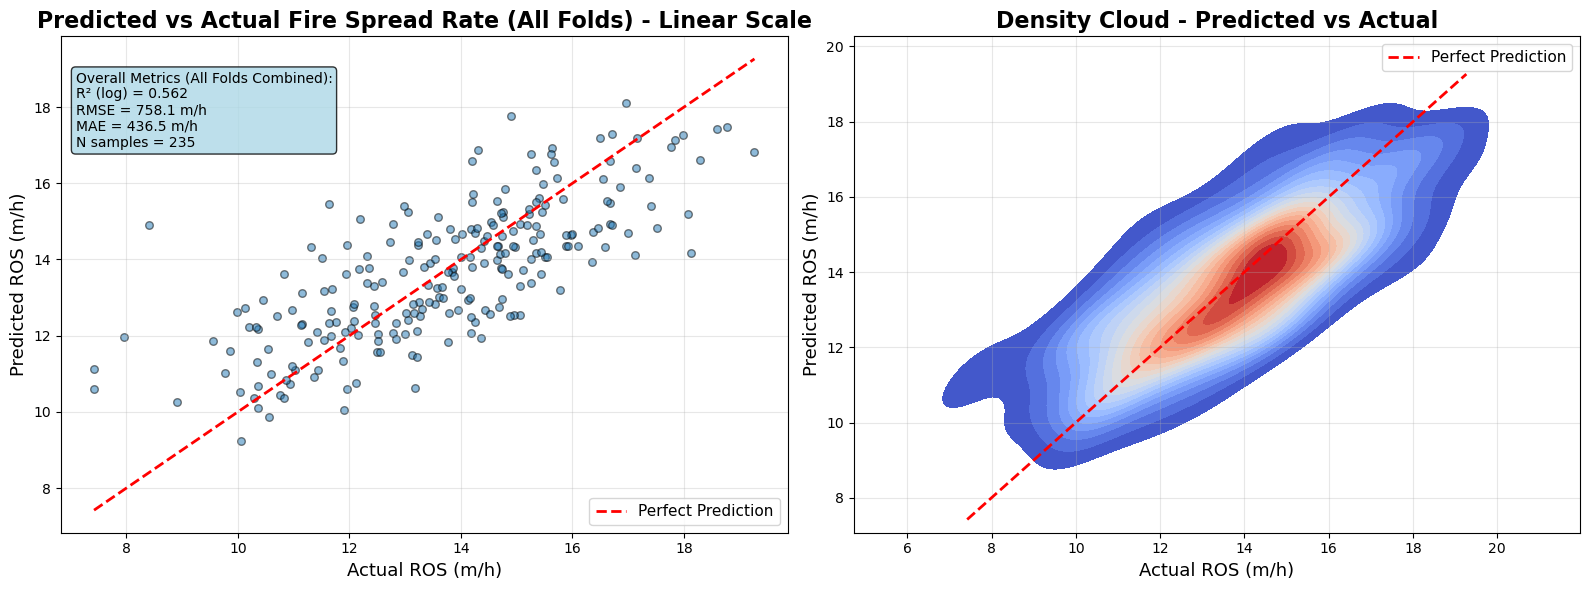

In [43]:
"""
The same plot as above but in linear scale with 2D KDE density plot
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6), gridspec_kw={'width_ratios': [1, 1]})

# Left panel: Scatter plot
ax1.scatter(y_val_log, y_val_pred_log, alpha=0.5, edgecolor='k', s=30)

min_val_linear = min(y_val_log.min(), y_val_pred_log.min())
max_val_linear = max(y_val_log.max(), y_val_pred_log.max())
ax1.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 'r--', linewidth=2, label='Perfect Prediction')

ax1.set_title('Predicted vs Actual Fire Spread Rate (All Folds) - Linear Scale', fontsize=16, fontweight='bold')
ax1.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax1.set_ylabel('Predicted ROS (m/h)', fontsize=13)

metrics_text = (
    f'Overall Metrics (All Folds Combined):\n'
    f'R² (log) = {r2_val:.3f}\n'
    f'RMSE = {rmse_linear_val:.1f} m/h\n'
    f'MAE = {mae_linear_val:.1f} m/h\n'
    f'N samples = {len(y_val_log)}'
)
ax1.text(0.02, 0.93, 
    metrics_text, 
    transform=ax1.transAxes, 
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
    fontsize=10)

ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Right panel: 2D KDE density plot
sns.kdeplot(x=y_val_log, y=y_val_pred_log, 
            ax=ax2, fill=True, cmap="coolwarm", 
            levels=20, thresh=0.04)
ax2.plot([min_val_linear, max_val_linear], [min_val_linear, max_val_linear], 
         'r--', linewidth=2, label='Perfect Prediction')

ax2.set_title('Density Cloud - Predicted vs Actual', fontsize=16, fontweight='bold')
ax2.set_xlabel('Actual ROS (m/h)', fontsize=13)
ax2.set_ylabel('Predicted ROS (m/h)', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Residuals analysis in log and linear scales


RESIDUAL ANALYSIS

RESIDUAL STATISTICS (Log Scale):
Mean Residual:        0.0324
Median Residual:      0.1465
Std Dev Residual:     1.4746
Min Residual:         -6.4948
Max Residual:         3.9589

RESIDUAL STATISTICS (Linear Scale):
Mean Residual:        0.03 m/h
Median Residual:      0.15 m/h
Std Dev Residual:     1.47 m/h
Min Residual:         -6.49 m/h
Max Residual:         3.96 m/h

Predictions within ±0.5 (log):   28.5%
Predictions within ±1.0 (log):   53.2%
Predictions within ±2.0 (log):   84.3%

Predictions within ±10 m/h:   100.0%
Predictions within ±50 m/h:   100.0%
Predictions within ±100 m/h:  100.0%

------------------------------------------------------------
SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):
------------------------------------------------------------

Range (log)     Count      Mean Error      RMSE           
------------------------------------------------------------
8-10            2             +0.7637           0.7665
10+           

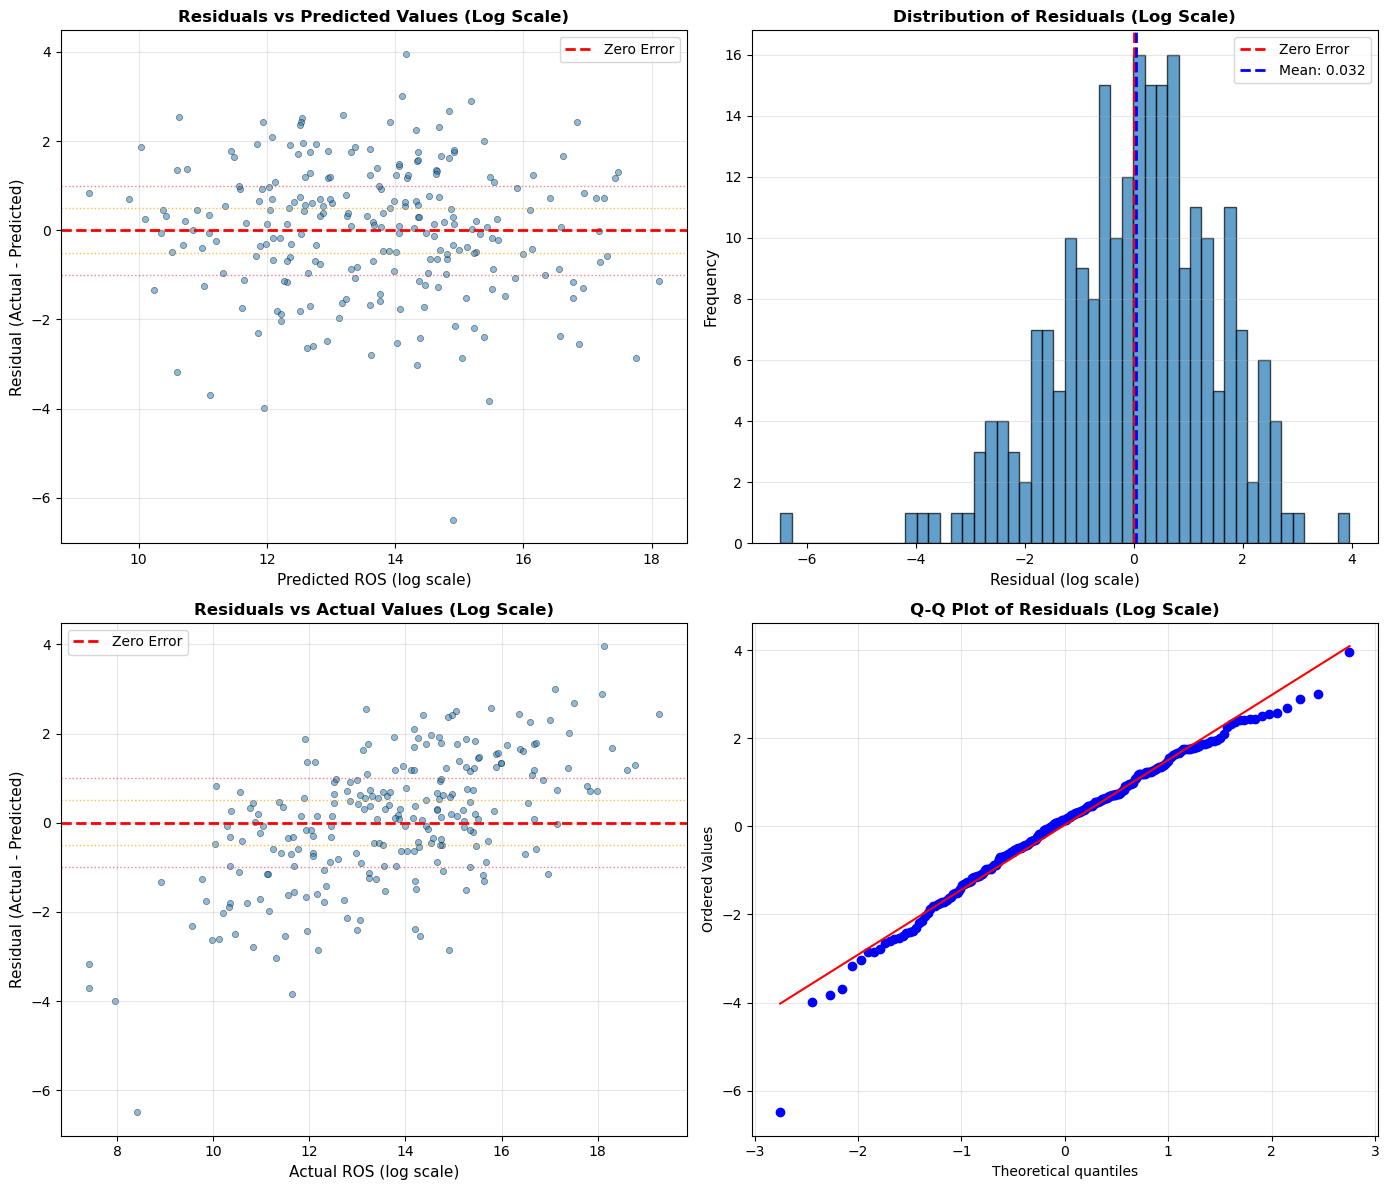

Residuals Plots (Linear Scale)


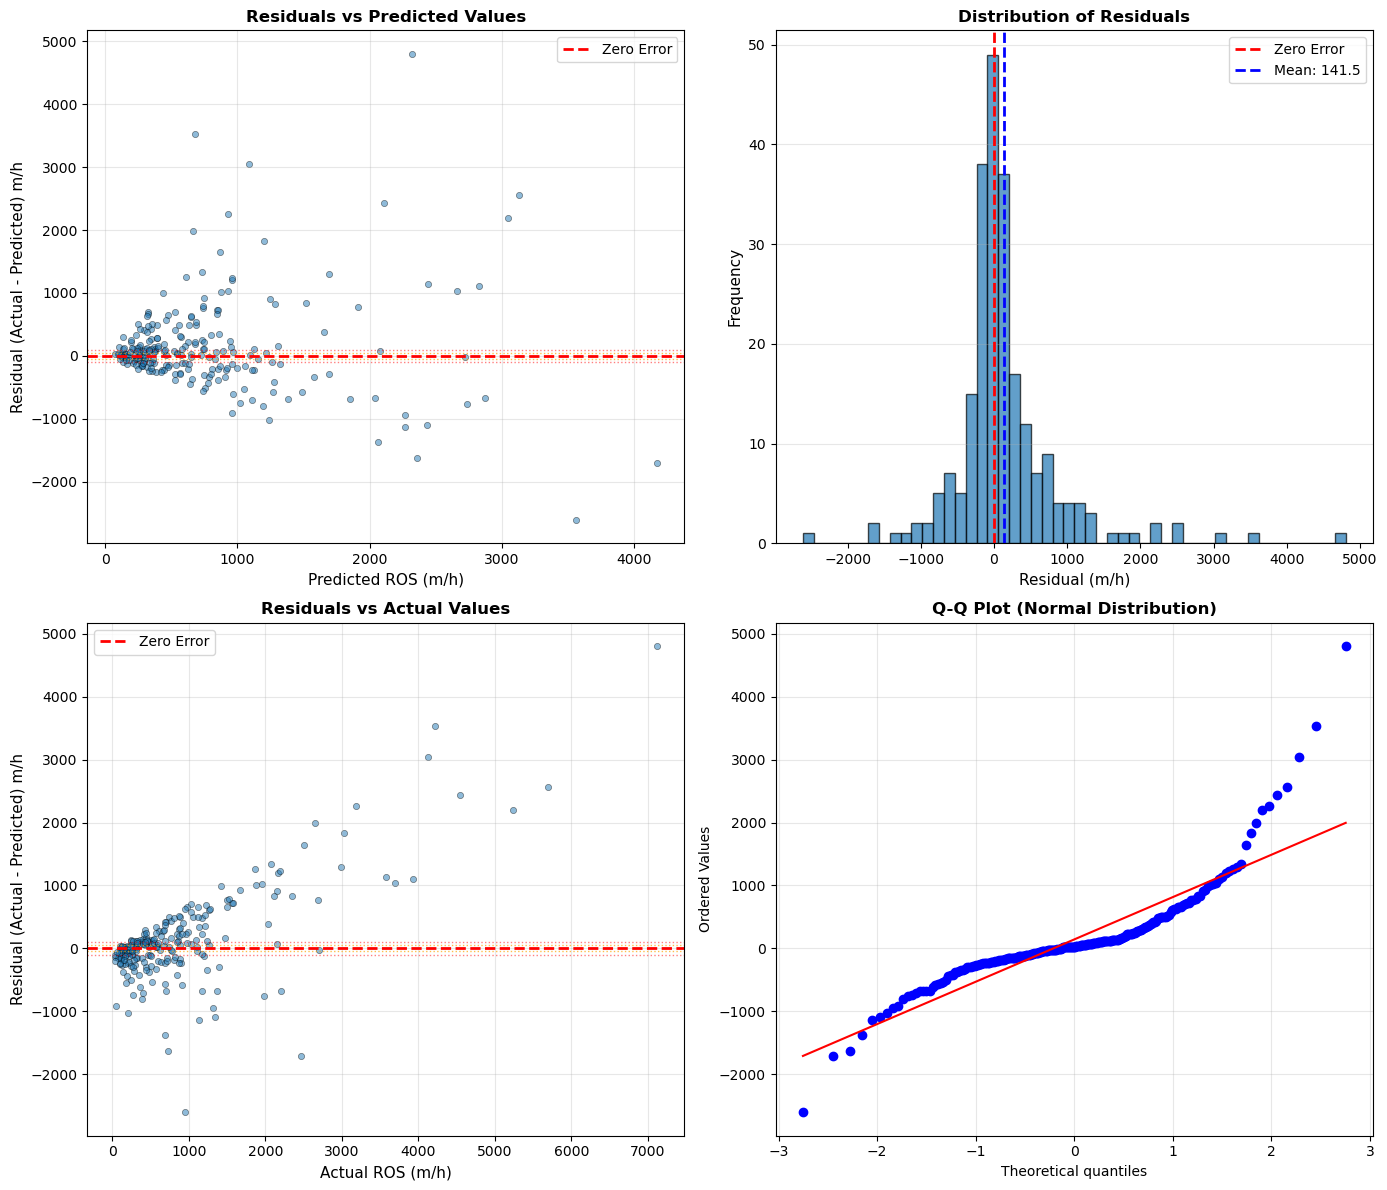


PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):
Mean Percentage Error:    -1.00%
Median Percentage Error:  +1.18%
Std Dev Percentage Error: 12.52%

✓ No significant systematic bias detected (mean error: 0.0 m/h)


In [44]:
print("\n" + "="*60)
print("RESIDUAL ANALYSIS")
print("="*60)

# Calculate residuals in both scales
residuals_log = y_val_log - y_val_pred_log
residuals_linear = y_val_linear - y_val_pred_linear

# Basic residual statistics - LOG SCALE
print("\nRESIDUAL STATISTICS (Log Scale):")
print(f"Mean Residual:        {np.mean(residuals_log):.4f}")
print(f"Median Residual:      {np.median(residuals_log):.4f}")
print(f"Std Dev Residual:     {np.std(residuals_log):.4f}")
print(f"Min Residual:         {np.min(residuals_log):.4f}")
print(f"Max Residual:         {np.max(residuals_log):.4f}")

# Basic residual statistics - LINEAR SCALE
print("\nRESIDUAL STATISTICS (Linear Scale):")
print(f"Mean Residual:        {np.mean(residuals_log):.2f} m/h")
print(f"Median Residual:      {np.median(residuals_log):.2f} m/h")
print(f"Std Dev Residual:     {np.std(residuals_log):.2f} m/h")
print(f"Min Residual:         {np.min(residuals_log):.2f} m/h")
print(f"Max Residual:         {np.max(residuals_log):.2f} m/h")

# Percentage of predictions within certain error bounds - LOG SCALE
within_0_5_log = np.sum(np.abs(residuals_log) <= 0.5) / len(residuals_log) * 100
within_1_log = np.sum(np.abs(residuals_log) <= 1.0) / len(residuals_log) * 100
within_2_log = np.sum(np.abs(residuals_log) <= 2.0) / len(residuals_log) * 100

print(f"\nPredictions within ±0.5 (log):   {within_0_5_log:.1f}%")
print(f"Predictions within ±1.0 (log):   {within_1_log:.1f}%")
print(f"Predictions within ±2.0 (log):   {within_2_log:.1f}%")

# Percentage of predictions within certain error bounds - LINEAR SCALE
within_10 = np.sum(np.abs(residuals_log) <= 10) / len(residuals_log) * 100
within_50 = np.sum(np.abs(residuals_log) <= 50) / len(residuals_log) * 100
within_100 = np.sum(np.abs(residuals_log) <= 100) / len(residuals_log) * 100

print(f"\nPredictions within ±10 m/h:   {within_10:.1f}%")
print(f"Predictions within ±50 m/h:   {within_50:.1f}%")
print(f"Predictions within ±100 m/h:  {within_100:.1f}%")

# Systematic error analysis - binned predictions - LOG SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LOG SCALE):")
print("-"*60)

# Create bins for analysis in log space
bins_log = [0, 2, 4, 6, 8, 10, np.inf]
bin_labels_log = ['0-2', '2-4', '4-6', '6-8', '8-10', '10+']

# Assign bins to predictions
bin_indices_log = np.digitize(y_val_pred_log, bins_log) - 1

print(f"\n{'Range (log)':<15} {'Count':<10} {'Mean Error':<15} {'RMSE':<15}")
print("-" * 60)

for i, label in enumerate(bin_labels_log):
    mask = bin_indices_log == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_log[mask])
        rmse_bin = np.sqrt(np.mean(residuals_log[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.4f}       {rmse_bin:>10.4f}")

# Systematic error analysis - binned predictions - LINEAR SCALE
print("\n" + "-"*60)
print("SYSTEMATIC ERROR ANALYSIS (by prediction magnitude - LINEAR SCALE):")
print("-"*60)

# Create bins for analysis
bins = [0, 50, 100, 200, 500, 1000, np.inf]
bin_labels = ['0-50', '50-100', '100-200', '200-500', '500-1000', '1000+']

# Assign bins to predictions
bin_indices = np.digitize(y_val_pred_log, bins) - 1

print(f"\n{'Range (m/h)':<15} {'Count':<10} {'Mean Error':<15} {'Mean % Error':<15} {'RMSE':<15}")
print("-" * 70)

for i, label in enumerate(bin_labels):
    mask = bin_indices == i
    if np.sum(mask) > 0:
        count = np.sum(mask)
        mean_error = np.mean(residuals_log[mask])
        mean_pct_error = np.mean((residuals_log[mask] / y_val_log[mask]) * 100)
        rmse_bin = np.sqrt(np.mean(residuals_log[mask]**2))
        print(f"{label:<15} {count:<10} {mean_error:>+10.2f} m/h  {mean_pct_error:>+10.1f}%     {rmse_bin:>10.2f} m/h")


# RESIDUAL PLOTS - LOG SCALE

print("Residual Plots (Log Scale)")

fig1, axes1 = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values (Log)
axes1[0, 0].scatter(y_val_pred_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 0].set_xlabel('Predicted ROS (log scale)', fontsize=11)
axes1[0, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[0, 0].set_title('Residuals vs Predicted Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 0].grid(True, alpha=0.3)
axes1[0, 0].legend()

# Add reference lines for ±0.5, ±1.0 log units
axes1[0, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[0, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[0, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals (Log)
axes1[0, 1].hist(residuals_log, bins=50, edgecolor='black', alpha=0.7)
axes1[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[0, 1].axvline(x=np.mean(residuals_log), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_log):.3f}')
axes1[0, 1].set_xlabel('Residual (log scale)', fontsize=11)
axes1[0, 1].set_ylabel('Frequency', fontsize=11)
axes1[0, 1].set_title('Distribution of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[0, 1].legend()
axes1[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values (Log)
axes1[1, 0].scatter(y_val_log, residuals_log, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes1[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes1[1, 0].set_xlabel('Actual ROS (log scale)', fontsize=11)
axes1[1, 0].set_ylabel('Residual (Actual - Predicted)', fontsize=11)
axes1[1, 0].set_title('Residuals vs Actual Values (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 0].grid(True, alpha=0.3)
axes1[1, 0].legend()

# Add reference lines
axes1[1, 0].axhline(y=0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=-0.5, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes1[1, 0].axhline(y=1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes1[1, 0].axhline(y=-1.0, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals) - Log
from scipy import stats
stats.probplot(residuals_log, dist="norm", plot=axes1[1, 1])
axes1[1, 1].set_title('Q-Q Plot of Residuals (Log Scale)', fontsize=12, fontweight='bold')
axes1[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# RESIDUAL PLOTS - LINEAR SCALE

print("Residuals Plots (Linear Scale)")

# 1. Residual vs Predicted (Linear Scale)
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: Residuals vs Predicted Values
axes[0, 0].scatter(y_val_pred_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 0].set_xlabel('Predicted ROS (m/h)', fontsize=11)
axes[0, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[0, 0].set_title('Residuals vs Predicted Values', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend()

# Add reference lines for ±50 and ±100 m/h errors
axes[0, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[0, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[0, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 2: Histogram of Residuals
axes[0, 1].hist(residuals_linear, bins=50, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[0, 1].axvline(x=np.mean(residuals_linear), color='blue', linestyle='--', linewidth=2, label=f'Mean: {np.mean(residuals_linear):.1f}')
axes[0, 1].set_xlabel('Residual (m/h)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('Distribution of Residuals', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Plot 3: Residuals vs Actual Values
axes[1, 0].scatter(y_val_linear, residuals_linear, alpha=0.5, s=20, edgecolor='k', linewidth=0.5)
axes[1, 0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Zero Error')
axes[1, 0].set_xlabel('Actual ROS (m/h)', fontsize=11)
axes[1, 0].set_ylabel('Residual (Actual - Predicted) m/h', fontsize=11)
axes[1, 0].set_title('Residuals vs Actual Values', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend()

# Add reference lines
axes[1, 0].axhline(y=50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=-50, color='orange', linestyle=':', linewidth=1, alpha=0.7)
axes[1, 0].axhline(y=100, color='red', linestyle=':', linewidth=1, alpha=0.5)
axes[1, 0].axhline(y=-100, color='red', linestyle=':', linewidth=1, alpha=0.5)

# Plot 4: Q-Q Plot (to check normality of residuals)
from scipy import stats
stats.probplot(residuals_linear, dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Normal Distribution)', fontsize=12, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# PERCENTAGE ERROR ANALYSIS

# Calculate percentage errors 
mask_nonzero = y_val_log > 1  # Only consider actual values > 1 m/h
pct_errors = (residuals_log[mask_nonzero] / y_val_log[mask_nonzero]) * 100

print("\n" + "="*60)
print("PERCENTAGE ERROR ANALYSIS (for actual ROS > 1 m/h):")
print("="*60)
print(f"Mean Percentage Error:    {np.mean(pct_errors):+.2f}%")
print(f"Median Percentage Error:  {np.median(pct_errors):+.2f}%")
print(f"Std Dev Percentage Error: {np.std(pct_errors):.2f}%")

# Systematic bias check
if np.abs(np.mean(residuals_log)) > 5:
    if np.mean(residuals_log) > 0:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to UNDERPREDICT by {np.mean(residuals_log):.1f} m/h on average")
    else:
        print(f"\nSYSTEMATIC BIAS DETECTED: Model tends to OVERPREDICT by {np.abs(np.mean(residuals_log)):.1f} m/h on average")
else:
    print(f"\n✓ No significant systematic bias detected (mean error: {np.mean(residuals_log):.1f} m/h)")

### Select bad predictions

DATA VALIDATION
Number of test observations: 235
Number of predictions: 235

Actual ROS statistics:
  Min: 29.50 m/h
  Max: 7123.35 m/h
  Mean: 897.91 m/h
  Median: 590.89 m/h

Predicted ROS statistics:
  Min: 69.20 m/h
  Max: 4178.20 m/h
  Mean: 756.39 m/h
  Median: 564.52 m/h

BAD PREDICTION DETECTION: ±35.0% THRESHOLD METHOD
Bad Prediction Definition: Predictions with |error| > ±35.0%
Number of bad predictions: 130 (55.3% of data)
Number of normal observations: 105 (44.7% of data)

Sample of 10 random predictions:
Actual       Predicted    % Error      Is Bad      
--------------------------------------------------
    1266.65     1218.87       -3.77% NO          
     140.64      121.03      -13.94% NO          
      80.36      234.41     +191.69% YES         
     315.65      206.33      -34.63% NO          
     519.48     1048.76     +101.89% YES         
    3024.40     1197.10      -60.42% YES         
    1173.61     1855.03      +58.06% YES         
     420.07      197.45 

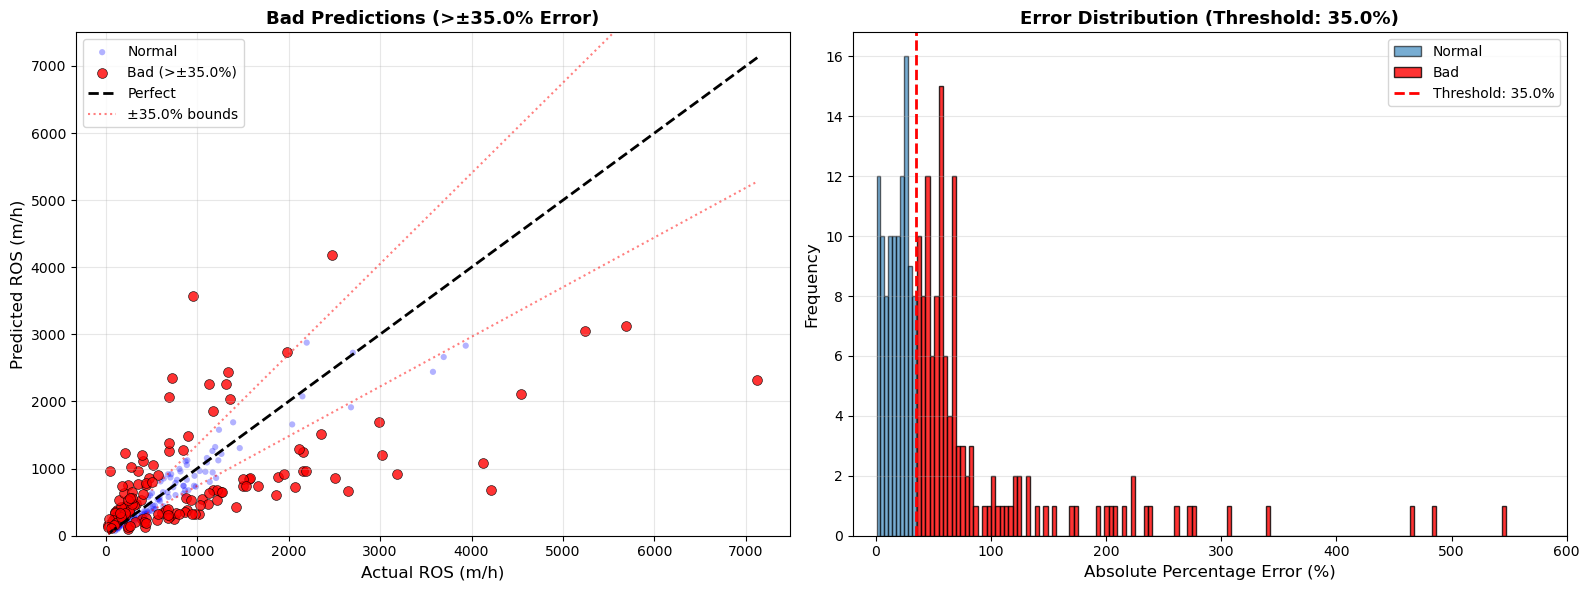

In [ ]:
# Configuration

output_path = '../../Data/Results/test_dataset_with_bad_preds.csv'
threshold = 35.0
tolerance = 0.001


print("=" * 80)
print("DATA VALIDATION")
print("=" * 80)
print(f"Number of test observations: {len(y_val_linear)}")
print(f"Number of predictions: {len(y_val_pred_linear)}")

print(f"\nActual ROS statistics:")
print(f"  Min: {y_val_linear.min():.2f} m/h")
print(f"  Max: {y_val_linear.max():.2f} m/h")
print(f"  Mean: {y_val_linear.mean():.2f} m/h")
print(f"  Median: {np.median(y_val_linear):.2f} m/h")

print(f"\nPredicted ROS statistics:")
print(f"  Min: {np.min(y_val_pred_linear):.2f} m/h")
print(f"  Max: {np.max(y_val_pred_linear):.2f} m/h")
print(f"  Mean: {np.mean(y_val_pred_linear):.2f} m/h")
print(f"  Median: {np.median(y_val_pred_linear):.2f} m/h")

# Calculate Errors
residuals = y_val_pred_linear - y_val_linear
abs_residuals = np.abs(residuals)

with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(y_val_linear != 0, (residuals / y_val_linear) * 100, 0)

percent_errors = np.abs(percent_errors_signed)

# Identify Bad Predictions
bad_pred_mask = percent_errors > threshold

print("\n" + "=" * 80)
print(f"BAD PREDICTION DETECTION: ±{threshold}% THRESHOLD METHOD")
print("=" * 80)
print(f"Bad Prediction Definition: Predictions with |error| > ±{threshold}%")
print(f"Number of bad predictions: {bad_pred_mask.sum()} ({bad_pred_mask.sum()/len(bad_pred_mask)*100:.1f}% of data)")
print(f"Number of normal observations: {(~bad_pred_mask).sum()} ({(~bad_pred_mask).sum()/len(bad_pred_mask)*100:.1f}% of data)")

# Sample Predictions
n_samples = 10
print(f"\nSample of {n_samples} random predictions:")
print(f"{'Actual':<12} {'Predicted':<12} {'% Error':<12} {'Is Bad':<12}")
print("-" * 50)

indices = np.random.choice(len(y_val_linear), min(n_samples, len(y_val_linear)), replace=False)
for idx in indices:
    actual = y_val_linear.iloc[idx]
    pred = y_val_pred_linear[idx]
    pct_err = percent_errors_signed[idx]
    is_bad = bad_pred_mask[idx]
    print(f"{actual:>11.2f} {pred:>11.2f} {pct_err:>+11.2f}% {'YES' if is_bad else 'NO':<12}")

# Error Statistics
print(f"\nBad Prediction Statistics:")
if bad_pred_mask.sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[bad_pred_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[bad_pred_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[bad_pred_mask].max():.1f}%")
else:
    print(f"  No bad predictions found (>±{threshold}%)")

print(f"\nNormal Predictions Statistics:")
if (~bad_pred_mask).sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[~bad_pred_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[~bad_pred_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[~bad_pred_mask].max():.1f}%")

# Create Predictions DataFrame
predictions_df = pd.DataFrame({
    'CV_Index': np.arange(len(y_val_linear)),
    'Actual_Linear': y_val_linear.values,
    'Predicted_Linear': y_val_pred_linear,
    'Residual_Linear': residuals,
    'Percent_Error': percent_errors_signed,
    'Abs_Percent_Error': percent_errors,
    'Abs_Residual_Lin': abs_residuals
})

# Match Predictions to Shapefile
print("\n" + "-" * 120)
print("MATCHING OBSERVATIONS TO ORIGINAL DATAFRAME...")
print("-" * 120)

matched_data = []
for _, row in predictions_df.iterrows():
    actual_ros = row['Actual_Linear']
    matches = df[np.abs(df['ros_p'] - actual_ros) < tolerance]
    
    match_dict = {
        'DF_Index': matches.index[0] if len(matches) > 0 else None,
        'CV_Index': row['CV_Index'],
        'Actual_ROS': actual_ros,
        'Predicted_ROS': row['Predicted_Linear'],
        'Error': row['Residual_Linear'],
        'Percent_Error': row['Percent_Error'],
        'Abs_Percent_Error': row['Abs_Percent_Error'],
        'Abs_Residual_Lin': row['Abs_Residual_Lin']
    }
    matched_data.append(match_dict)

matched_df = pd.DataFrame(matched_data)
matched_count = matched_df['DF_Index'].notna().sum()
print(f"Successfully matched {matched_count} out of {len(matched_df)} total observations")

# Top Worst Predictions
n_top = 50
print("\n" + "-" * 140)
print(f"TOP {n_top} WORST PREDICTIONS (>±{threshold}% error):")
print("-" * 140)
print(f"{'DF_Idx':<10} {'CV_Idx':<8} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_%Err':<12}")
print("-" * 140)

worst = matched_df[matched_df['Abs_Percent_Error'] > threshold].sort_values('Abs_Percent_Error', ascending=False).head(n_top)
for _, row in worst.iterrows():
    df_idx_str = str(row['DF_Index']) if pd.notna(row['DF_Index']) else 'NOT_FOUND'
    print(f"{df_idx_str:<10} {int(row['CV_Index']):<8} {row['Actual_ROS']:>11.1f} {row['Predicted_ROS']:>11.1f} {row['Error']:>+11.1f} {row['Percent_Error']:>+9.1f}% {row['Abs_Percent_Error']:>11.1f}%")

# Add Predictions to Shapefile
print("\n" + "=" * 60)
print("ADDING PREDICTIONS TO DATAFRAME")
print("=" * 60)

df_updated = df.copy()

# Inicializar colunas; usar dtype=object para suportar NaN + bool
df_updated['bad_pred'] = pd.Series([np.nan] * len(df_updated), dtype='object')
df_updated['Pred_ROS'] = np.nan
df_updated['Pred_Error'] = np.nan
df_updated['Pct_Error'] = np.nan
df_updated['AbsPctErr'] = np.nan

# Inserir previsões nas linhas correspondentes
valid_matches = matched_df[matched_df['DF_Index'].notna()].copy()
if len(valid_matches) > 0:
    indices = valid_matches['DF_Index'].astype(int).tolist()
    df_updated.loc[indices, 'Pred_ROS']   = valid_matches['Predicted_ROS'].values
    df_updated.loc[indices, 'Pred_Error'] = valid_matches['Error'].values
    df_updated.loc[indices, 'Pct_Error']  = valid_matches['Percent_Error'].values
    df_updated.loc[indices, 'AbsPctErr']  = valid_matches['Abs_Percent_Error'].values

# Avaliar bad predictions apenas para linhas com previsão
pred_mask = df_updated['Pred_ROS'].notna()
df_updated.loc[pred_mask, 'bad_pred'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold

bad_pred_count = df_updated['bad_pred'].sum()
print(f"\nAdded predictions to {len(indices)} observations")
print(f"Marked {int(bad_pred_count)} observations as bad predictions (>±{threshold}% error)")

# Overall Statistics
all_with_pred = df_updated[df_updated['Pred_ROS'].notna()]
bad_preds = df_updated[df_updated['bad_pred'] == True]

print("\n" + "-" * 60)
print("OVERALL STATISTICS:")
print("-" * 60)
print(f"Total observations: {len(df_updated)}")
print(f"Observations with predictions: {len(all_with_pred)} ({len(all_with_pred)/len(df_updated)*100:.2f}%)")
print(f"Number of bad predictions: {len(bad_preds)} ({len(bad_preds)/len(all_with_pred)*100:.2f}%)")

print(f"\nAll Predictions:")
print(f"  Mean Actual ROS: {all_with_pred['ros_p'].mean():.1f} m/h")
print(f"  Mean Predicted ROS: {all_with_pred['Pred_ROS'].mean():.1f} m/h")
print(f"  Mean Absolute Error: {np.abs(all_with_pred['Pred_Error']).mean():.1f} m/h")
print(f"  Mean Absolute Percentage Error: {all_with_pred['AbsPctErr'].mean():.1f}%")
print(f"  Mean Percentage Error: {all_with_pred['Pct_Error'].mean():+.1f}%")

if len(bad_preds) > 0:
    print(f"\nBad Predictions Only (>±{threshold}% error):")
    print(f"  Mean Actual ROS: {bad_preds['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS: {bad_preds['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error: {np.abs(bad_preds['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Absolute Percentage Error: {bad_preds['AbsPctErr'].mean():.1f}%")
    print(f"  Mean Percentage Error: {bad_preds['Pct_Error'].mean():+.1f}%")

# Prediction Bias
all_overpred = all_with_pred[all_with_pred['Pred_Error'] > 0]
all_underpred = all_with_pred[all_with_pred['Pred_Error'] < 0]
print(f"\nOverall Prediction Bias:")
print(f"  Overpredictions: {len(all_overpred)} ({len(all_overpred)/len(all_with_pred)*100:.1f}%)")
print(f"  Underpredictions: {len(all_underpred)} ({len(all_underpred)/len(all_with_pred)*100:.1f}%)")

if len(bad_preds) > 0:
    bad_overpred = bad_preds[bad_preds['Pred_Error'] > 0]
    bad_underpred = bad_preds[bad_preds['Pred_Error'] < 0]
    print(f"\nBad Prediction Bias:")
    print(f"  Overpredictions: {len(bad_overpred)} ({len(bad_overpred)/len(bad_preds)*100:.1f}%)")
    print(f"  Underpredictions: {len(bad_underpred)} ({len(bad_underpred)/len(bad_preds)*100:.1f}%)")

# Save Shapefile
df_to_save = df_updated.copy()
column_mapping = {'Pred_ROS': 'PredROS', 'Pred_Error': 'PredErr', 'Pct_Error': 'PctErr', 'AbsPctErr': 'AbsPctErr'}
df_to_save.rename(columns=column_mapping, inplace=True)
df_to_save.to_csv(output_path, index=False)

print(f"\n✓ Shapefile saved to: {output_path}")
print(f"\nNew columns: bad_pred, PredROS, PredErr, PctErr, AbsPctErr")

# Quick Access Guide
print("\n" + "=" * 60)
print("QUICK ACCESS:")
print("=" * 60)
print("All predictions: df_updated[df_updated['Pred_ROS'].notna()]")
print(f"Bad predictions: df_updated[df_updated['bad_pred'] == True]")
print("Normal predictions: df_updated[df_updated['bad_pred'] == False]")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_val_linear[~bad_pred_mask], y_val_pred_linear[~bad_pred_mask], 
               alpha=0.3, s=20, c='blue', label='Normal', edgecolor='none')
axes[0].scatter(y_val_linear[bad_pred_mask], y_val_pred_linear[bad_pred_mask], 
               alpha=0.8, s=50, c='red', label=f'Bad (>±{threshold}%)', edgecolor='black', linewidth=0.5)

min_val = min(y_val_linear.min(), y_val_pred_linear.min())
max_val = max(y_val_linear.max(), y_val_pred_linear.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')

x_range = np.linspace(min_val, max_val, 100)
threshold_factor = 1 + (threshold / 100)
axes[0].plot(x_range, x_range * threshold_factor, 'r:', linewidth=1.5, alpha=0.5, label=f'±{threshold}% bounds')
axes[0].plot(x_range, x_range / threshold_factor, 'r:', linewidth=1.5, alpha=0.5)

axes[0].set_xlabel('Actual ROS (m/h)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (m/h)', fontsize=12)
axes[0].set_title(f'Bad Predictions (>±{threshold}% Error)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0, 7500)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(percent_errors[~bad_pred_mask], bins=10, alpha=0.6, label='Normal', edgecolor='black')
axes[1].hist(percent_errors[bad_pred_mask], bins=500, alpha=0.8, color='red', label='Bad', edgecolor='black')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold: {threshold}%')
axes[1].set_xlabel('Absolute Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlim(-20, 600)
axes[1].set_title(f'Error Distribution (Threshold: {threshold}%)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Obtain outliers

DATA VALIDATION
Number of test observations: 235
Number of predictions: 235

Actual ROS statistics:
  Min: 29.50 m/h
  Max: 7123.35 m/h
  Mean: 897.91 m/h
  Median: 590.89 m/h

Predicted ROS statistics:
  Min: 69.20 m/h
  Max: 4178.20 m/h
  Mean: 756.39 m/h
  Median: 564.52 m/h

OUTLIER DETECTION: 95TH PERCENTILE METHOD
Calculated 95th percentile threshold: 222.95%
Outlier Definition: Predictions with |error| > 222.95%
Number of outliers: 12 (5.1% of data)
Number of normal observations: 223 (94.9% of data)

Sample of 10 random predictions:
Actual       Predicted    % Error      Is Outlier  
--------------------------------------------------
    3936.86     2831.58      -28.08% NO          
     310.57      290.24       -6.55% NO          
     590.89      570.75       -3.41% NO          
     128.23       92.71      -27.70% NO          
     198.62      640.56     +222.51% NO          
    1221.83      526.14      -56.94% NO          
     147.60      146.66       -0.63% NO          
 

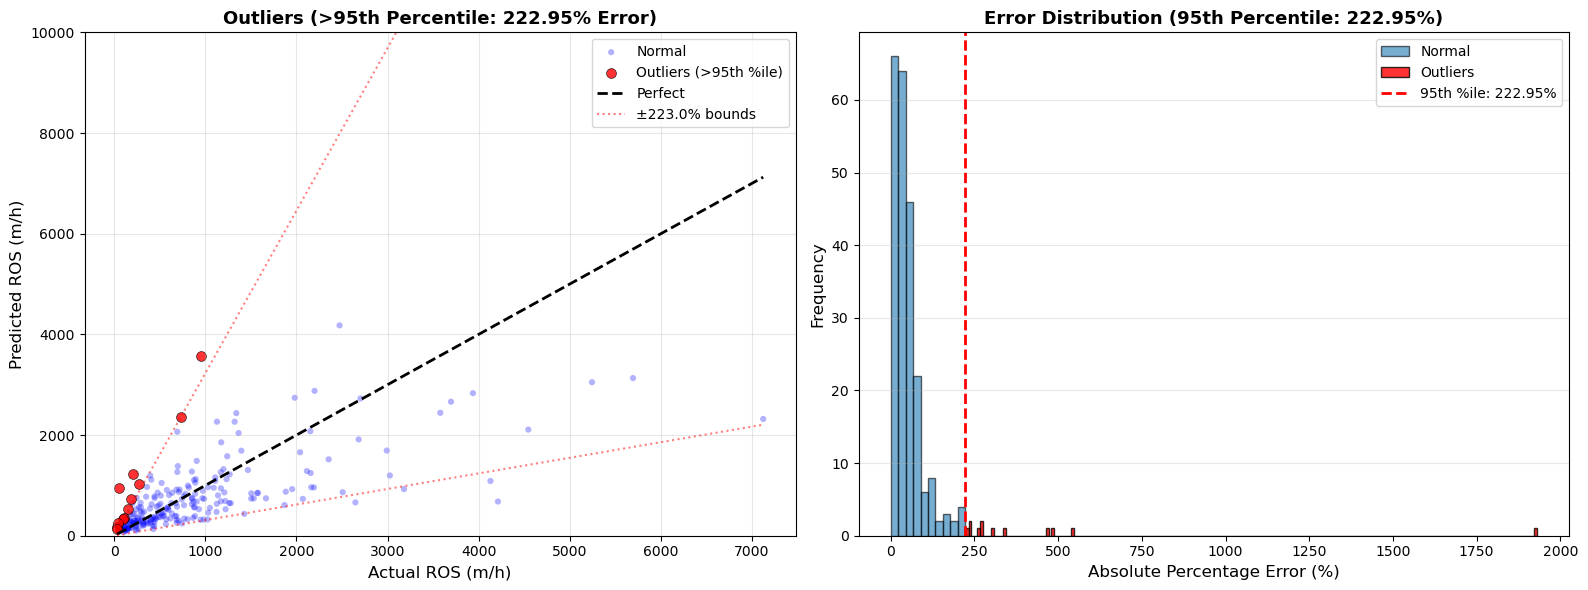

In [63]:
# Configuration
output_path = '../../Data/Results/test_dataset_with_outliers.csv'
percentile_threshold = 95
tolerance = 0.001


print("=" * 80)
print("DATA VALIDATION")
print("=" * 80)
print(f"Number of test observations: {len(y_val_linear)}")
print(f"Number of predictions: {len(y_val_pred_linear)}")

print(f"\nActual ROS statistics:")
print(f"  Min: {y_val_linear.min():.2f} m/h")
print(f"  Max: {y_val_linear.max():.2f} m/h")
print(f"  Mean: {y_val_linear.mean():.2f} m/h")
print(f"  Median: {np.median(y_val_linear):.2f} m/h")

print(f"\nPredicted ROS statistics:")
print(f"  Min: {np.min(y_val_pred_linear):.2f} m/h")
print(f"  Max: {np.max(y_val_pred_linear):.2f} m/h")
print(f"  Mean: {np.mean(y_val_pred_linear):.2f} m/h")
print(f"  Median: {np.median(y_val_pred_linear):.2f} m/h")

# Calculate Errors
residuals = y_val_pred_linear - y_val_linear
abs_residuals = np.abs(residuals)

with np.errstate(divide='ignore', invalid='ignore'):
    percent_errors_signed = np.where(y_val_linear != 0, (residuals / y_val_linear) * 100, 0)

percent_errors = np.abs(percent_errors_signed)

# Calculate 95th percentile threshold
threshold = np.percentile(percent_errors, percentile_threshold)

# Identify Outliers (above 95th percentile)
outlier_mask = percent_errors > threshold

print("\n" + "=" * 80)
print(f"OUTLIER DETECTION: {percentile_threshold}TH PERCENTILE METHOD")
print("=" * 80)
print(f"Calculated {percentile_threshold}th percentile threshold: {threshold:.2f}%")
print(f"Outlier Definition: Predictions with |error| > {threshold:.2f}%")
print(f"Number of outliers: {outlier_mask.sum()} ({outlier_mask.sum()/len(outlier_mask)*100:.1f}% of data)")
print(f"Number of normal observations: {(~outlier_mask).sum()} ({(~outlier_mask).sum()/len(outlier_mask)*100:.1f}% of data)")

# Sample Predictions
n_samples = 10
print(f"\nSample of {n_samples} random predictions:")
print(f"{'Actual':<12} {'Predicted':<12} {'% Error':<12} {'Is Outlier':<12}")
print("-" * 50)

indices = np.random.choice(len(y_val_linear), min(n_samples, len(y_val_linear)), replace=False)
for idx in indices:
    actual = y_val_linear.iloc[idx]
    pred = y_val_pred_linear[idx]
    pct_err = percent_errors_signed[idx]
    is_outlier = outlier_mask[idx]
    print(f"{actual:>11.2f} {pred:>11.2f} {pct_err:>+11.2f}% {'YES' if is_outlier else 'NO':<12}")

# Error Statistics
print(f"\nOutlier Statistics (>{percentile_threshold}th percentile: {threshold:.2f}%):")
if outlier_mask.sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[outlier_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[outlier_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[outlier_mask].max():.1f}%")
else:
    print(f"  No outliers found (>{percentile_threshold}th percentile)")

print(f"\nNormal Predictions Statistics (<={percentile_threshold}th percentile: {threshold:.2f}%):")
if (~outlier_mask).sum() > 0:
    print(f"  Mean absolute percentage error: {percent_errors[~outlier_mask].mean():.1f}%")
    print(f"  Median absolute percentage error: {np.median(percent_errors[~outlier_mask]):.1f}%")
    print(f"  Max absolute percentage error: {percent_errors[~outlier_mask].max():.1f}%")

# Create Predictions DataFrame
predictions_df = pd.DataFrame({
    'CV_Index': np.arange(len(y_val_linear)),
    'Actual_Linear': y_val_linear.values,
    'Predicted_Linear': y_val_pred_linear,
    'Residual_Linear': residuals,
    'Percent_Error': percent_errors_signed,
    'Abs_Percent_Error': percent_errors,
    'Abs_Residual_Lin': abs_residuals
})

# Match Predictions to Shapefile
print("\n" + "-" * 120)
print("MATCHING OBSERVATIONS TO ORIGINAL DATAFRAME...")
print("-" * 120)

matched_data = []
for _, row in predictions_df.iterrows():
    actual_ros = row['Actual_Linear']
    matches = df[np.abs(df['ros_p'] - actual_ros) < tolerance]
    
    match_dict = {
        'DF_Index': matches.index[0] if len(matches) > 0 else None,
        'CV_Index': row['CV_Index'],
        'Actual_ROS': actual_ros,
        'Predicted_ROS': row['Predicted_Linear'],
        'Error': row['Residual_Linear'],
        'Percent_Error': row['Percent_Error'],
        'Abs_Percent_Error': row['Abs_Percent_Error'],
        'Abs_Residual_Lin': row['Abs_Residual_Lin']
    }
    matched_data.append(match_dict)

matched_df = pd.DataFrame(matched_data)
matched_count = matched_df['DF_Index'].notna().sum()
print(f"Successfully matched {matched_count} out of {len(matched_df)} total observations")

# Top Worst Predictions
n_top = 50
print("\n" + "-" * 140)
print(f"TOP {n_top} WORST PREDICTIONS (>{percentile_threshold}th percentile: {threshold:.2f}% error):")
print("-" * 140)
print(f"{'DF_Idx':<10} {'CV_Idx':<8} {'Actual(m/h)':<12} {'Pred(m/h)':<12} {'Error(m/h)':<12} {'%Error':<10} {'Abs_%Err':<12}")
print("-" * 140)

worst = matched_df[matched_df['Abs_Percent_Error'] > threshold].sort_values('Abs_Percent_Error', ascending=False).head(n_top)
for _, row in worst.iterrows():
    df_idx_str = str(row['DF_Index']) if pd.notna(row['DF_Index']) else 'NOT_FOUND'
    print(f"{df_idx_str:<10} {int(row['CV_Index']):<8} {row['Actual_ROS']:>11.1f} {row['Predicted_ROS']:>11.1f} {row['Error']:>+11.1f} {row['Percent_Error']:>+9.1f}% {row['Abs_Percent_Error']:>11.1f}%")

print("\n" + "=" * 60)
print("ADDING PREDICTIONS TO DATAFRAME")
print("=" * 60)

df_updated = df.copy()

# Initialize columns
df_updated['outliers'] = pd.Series([np.nan]*len(df_updated), dtype='object')
df_updated['Pred_ROS'] = np.nan
df_updated['Pred_Error'] = np.nan
df_updated['Pct_Error'] = np.nan
df_updated['AbsPctErr'] = np.nan

# Insert predictions into the matching rows
valid_matches = matched_df[matched_df['DF_Index'].notna()].copy()

if len(valid_matches) > 0:
    indices = valid_matches['DF_Index'].astype(int).tolist()

    df_updated.loc[indices, 'Pred_ROS']     = valid_matches['Predicted_ROS'].values
    df_updated.loc[indices, 'Pred_Error']   = valid_matches['Error'].values
    df_updated.loc[indices, 'Pct_Error']    = valid_matches['Percent_Error'].values
    df_updated.loc[indices, 'AbsPctErr']    = valid_matches['Abs_Percent_Error'].values

    print(f"\nAdded predictions to {len(indices)} observations")

# --- NOW evaluate outliers (ONLY for rows with predictions) ---
pred_mask = df_updated['Pred_ROS'].notna()
df_updated.loc[pred_mask, 'outliers'] = df_updated.loc[pred_mask, 'AbsPctErr'] > threshold

outlier_count = df_updated['outliers'].sum()
print(f"Marked {int(outlier_count)} observations as outliers (>{percentile_threshold}th percentile: {threshold:.2f}% error)")

# Overall Statistics
all_with_pred = df_updated[df_updated['Pred_ROS'].notna()]
outliers = df_updated[df_updated['outliers'] == True]

print("\n" + "-" * 60)
print("OVERALL STATISTICS:")
print("-" * 60)
print(f"Total observations: {len(df_updated)}")
print(f"Observations with predictions: {len(all_with_pred)} ({len(all_with_pred)/len(df_updated)*100:.2f}%)")
print(f"Number of outliers: {len(outliers)} ({len(outliers)/len(all_with_pred)*100:.2f}%)")

print(f"\nAll Predictions:")
print(f"  Mean Actual ROS: {all_with_pred['ros_p'].mean():.1f} m/h")
print(f"  Mean Predicted ROS: {all_with_pred['Pred_ROS'].mean():.1f} m/h")
print(f"  Mean Absolute Error: {np.abs(all_with_pred['Pred_Error']).mean():.1f} m/h")
print(f"  Mean Absolute Percentage Error: {all_with_pred['AbsPctErr'].mean():.1f}%")
print(f"  Mean Percentage Error: {all_with_pred['Pct_Error'].mean():+.1f}%")

if len(outliers) > 0:
    print(f"\nOutliers Only (>{percentile_threshold}th percentile: {threshold:.2f}% error):")
    print(f"  Mean Actual ROS: {outliers['ros_p'].mean():.1f} m/h")
    print(f"  Mean Predicted ROS: {outliers['Pred_ROS'].mean():.1f} m/h")
    print(f"  Mean Absolute Error: {np.abs(outliers['Pred_Error']).mean():.1f} m/h")
    print(f"  Mean Absolute Percentage Error: {outliers['AbsPctErr'].mean():.1f}%")
    print(f"  Mean Percentage Error: {outliers['Pct_Error'].mean():+.1f}%")

# Prediction Bias
all_overpred = all_with_pred[all_with_pred['Pred_Error'] > 0]
all_underpred = all_with_pred[all_with_pred['Pred_Error'] < 0]
print(f"\nOverall Prediction Bias:")
print(f"  Overpredictions: {len(all_overpred)} ({len(all_overpred)/len(all_with_pred)*100:.1f}%)")
print(f"  Underpredictions: {len(all_underpred)} ({len(all_underpred)/len(all_with_pred)*100:.1f}%)")

if len(outliers) > 0:
    outlier_overpred = outliers[outliers['Pred_Error'] > 0]
    outlier_underpred = outliers[outliers['Pred_Error'] < 0]
    print(f"\nOutlier Prediction Bias:")
    print(f"  Overpredictions: {len(outlier_overpred)} ({len(outlier_overpred)/len(outliers)*100:.1f}%)")
    print(f"  Underpredictions: {len(outlier_underpred)} ({len(outlier_underpred)/len(outliers)*100:.1f}%)")

# Save Shapefile
df_to_save = df_updated.copy()
column_mapping = {'Pred_ROS': 'PredROS', 'Pred_Error': 'PredErr', 'Pct_Error': 'PctErr', 'AbsPctErr': 'AbsPctErr'}
df_to_save.rename(columns=column_mapping, inplace=True)
df_to_save.to_csv(output_path, index=False)


print(f"\n✓ Shapefile saved to: {output_path}")
print(f"\nNew columns: outliers, PredROS, PredErr, PctErr, AbsPctErr")

# Quick Access Guide
print("\n" + "=" * 60)
print("QUICK ACCESS:")
print("=" * 60)
print("All predictions: df_updated[df_updated['Pred_ROS'].notna()]")
print(f"Outliers: df_updated[df_updated['outliers'] == True]")
print("Normal predictions: df_updated[df_updated['outliers'] == False]")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Scatter plot
axes[0].scatter(y_val_linear[~outlier_mask], y_val_pred_linear[~outlier_mask], 
               alpha=0.3, s=20, c='blue', label='Normal', edgecolor='none')
axes[0].scatter(y_val_linear[outlier_mask], y_val_pred_linear[outlier_mask], 
               alpha=0.8, s=50, c='red', label=f'Outliers (>{percentile_threshold}th %ile)', edgecolor='black', linewidth=0.5)

min_val = min(y_val_linear.min(), y_val_pred_linear.min())
max_val = max(y_val_linear.max(), y_val_pred_linear.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'k--', linewidth=2, label='Perfect')

x_range = np.linspace(min_val, max_val, 100)
threshold_factor = 1 + (threshold / 100)
axes[0].plot(x_range, x_range * threshold_factor, 'r:', linewidth=1.5, alpha=0.5, label=f'±{threshold:.1f}% bounds')
axes[0].plot(x_range, x_range / threshold_factor, 'r:', linewidth=1.5, alpha=0.5)

axes[0].set_xlabel('Actual ROS (m/h)', fontsize=12)
axes[0].set_ylabel('Predicted ROS (m/h)', fontsize=12)
axes[0].set_title(f'Outliers (>{percentile_threshold}th Percentile: {threshold:.2f}% Error)', fontsize=13, fontweight='bold')
axes[0].set_ylim(0,10000)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Histogram
axes[1].hist(percent_errors[~outlier_mask], bins=10, alpha=0.6, label='Normal', edgecolor='black')
axes[1].hist(percent_errors[outlier_mask], bins=200, alpha=0.8, color='red', label='Outliers', edgecolor='black')
axes[1].axvline(x=threshold, color='red', linestyle='--', linewidth=2, label=f'{percentile_threshold}th %ile: {threshold:.2f}%')
axes[1].set_xlabel('Absolute Percentage Error (%)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title(f'Error Distribution ({percentile_threshold}th Percentile: {threshold:.2f}%)', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [47]:
sample_df = pd.DataFrame({
    'Actual ROS': y_val_log,
    'Predicted ROS': y_val_pred_log
}).reset_index(drop=True)

# Randomly sample 10 rows
sample_10 = sample_df.sample(20).copy()

# Compute % error
sample_10['% Error'] = ((sample_10['Predicted ROS'] - sample_10['Actual ROS']) / sample_10['Actual ROS']) * 100

print("Sample of 10 predictions vs actual ROS values:\n")
display(sample_10)

Sample of 10 predictions vs actual ROS values:



,Actual ROS,Predicted ROS,% Error
53,12.434400,13.304896,7.000714
193,12.149444,12.009087,-1.155261
206,15.344399,14.874028,-3.065422
226,10.556834,9.858986,-6.610390
63,16.668444,15.478460,-7.139142
13,12.999558,12.041569,-7.369401
214,14.882594,12.515926,-15.902253
125,15.252365,13.379067,-12.282014
143,15.343095,14.178811,-7.588323
207,17.513213,14.835398,-15.290258


### SHAP

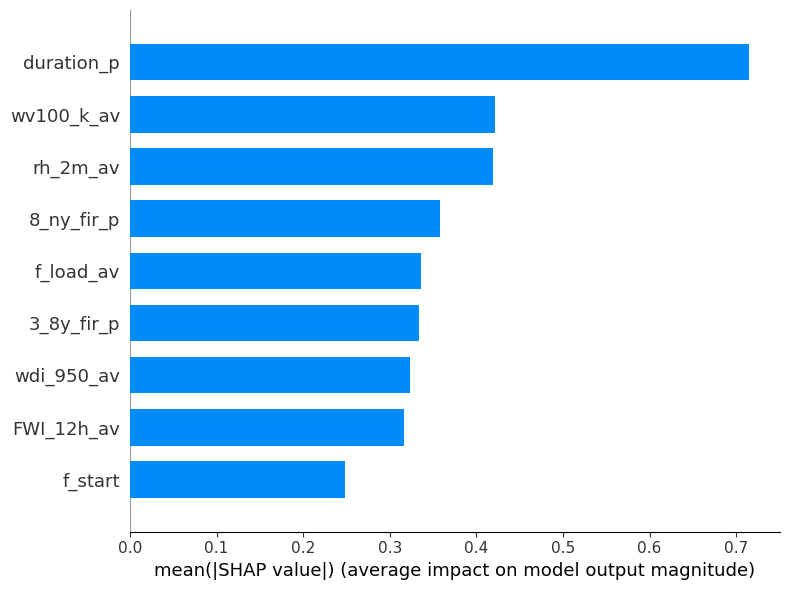

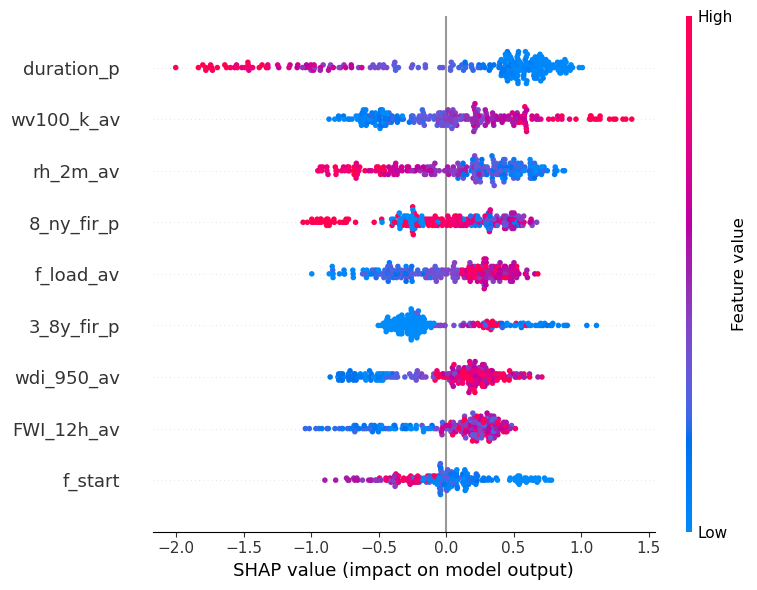


Mean |SHAP| for top 20 variables:
duration_p    0.714927
wv100_k_av    0.421762
rh_2m_av      0.418878
8_ny_fir_p    0.358543
f_load_av     0.336035
3_8y_fir_p    0.333490
wdi_950_av    0.322909
FWI_12h_av    0.316936
f_start       0.248816
dtype: float32


In [48]:
# calcular valores SHAP
explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X_val[train_features])
shap_values_abs = np.abs(shap_values)

# Plots
shap.summary_plot(shap_values, X_val[train_features], plot_type="bar", plot_size=(8,6))
shap.summary_plot(shap_values, X_val[train_features], plot_size=(8,6))

#for name in X_val.columns:
#    shap.dependence_plot(name, shap_values, X_val, display_features=X_val)

# List top 20 variables by mean |SHAP| value
mean_SHAP_values = pd.Series(
    np.abs(shap_values).mean(axis=0),
    index=X_val[train_features].columns
).sort_values(ascending=False)

print("\nMean |SHAP| for top 20 variables:")
print(mean_SHAP_values.head(20))

# merge results with final.shp and save to final_with_SHAP.shp
shap_df = X_val.copy()

shap_columns = pd.DataFrame(
    shap_values_abs,
    columns=[f'SHAP_{col}' for col in X_val[train_features].columns],
    index=X_val.index
)

# criar a shap_df que contem as colunas e rows do X_val + colunas SHAP
shap_df = pd.concat([shap_df, shap_columns], axis=1)

X_val_with_shap = df.merge(shap_df, on='row_id', how='left')

X_val_with_shap.to_csv('../../Data/Results/test_dataset_with_SHAP.csv')

### Merge the outlier and SHAP dataframes into 1 and delete them

In [49]:
import pandas as pd

# File paths
shap_path = r'../../Data/Results/test_dataset_with_SHAP.csv'
outliers_path = r'../../Data/Results/test_dataset_with_outliers.csv'
bad_preds_path = r'../../Data/Results/test_dataset_with_bad_preds.csv'
output_path = r'../../Data/Results/test_dataset_merged.csv'

# Load CSVs
shap_df = pd.read_csv(shap_path)
outliers_df = pd.read_csv(outliers_path)
bad_preds_df = pd.read_csv(bad_preds_path)

# Definir coluna de chave para merge
key_col = 'row_id'  # ou 'CV_Index', se for o caso

# Selecionar apenas as colunas relevantes de cada CSV
shap_cols = [c for c in shap_df.columns if c.startswith('SHAP_')] + [key_col]
outlier_cols = ['ros_p', 'outliers', 'PredROS', 'PredErr', 'PctErr', 'AbsPctErr', key_col]
bad_pred_cols = ['bad_pred', key_col]

# Subconjuntos
shap_subset = shap_df[shap_cols]
outlier_subset = outliers_df[outlier_cols]
bad_pred_subset = bad_preds_df[bad_pred_cols]

# Merge passo a passo pelo identificador
merged = shap_subset.merge(outlier_subset, on=key_col, how='left')
merged = merged.merge(bad_pred_subset, on=key_col, how='left')

# Ordenar
merged = merged.sort_values('PredROS')
merged = merged.drop(columns=[key_col])

# Salvar
merged.to_csv(output_path, index=False)
print(f"Saved: {output_path}")
print(f"Total columns: {len(merged.columns)}")
print(f"\nColumns: {list(merged.columns)}")


'''for path in [shap_path, outliers_path, bad_preds_path]:
    base = path.rsplit('.', 1)[0]
    for f in glob.glob(f"{base}.*"):
        os.remove(f)
        print(f"Deleted: {f}")'''

Saved: ../../Data/Results/test_dataset_merged.csv
Total columns: 16

Columns: ['SHAP_duration_p', 'SHAP_3_8y_fir_p', 'SHAP_wv100_k_av', 'SHAP_f_load_av', 'SHAP_FWI_12h_av', 'SHAP_rh_2m_av', 'SHAP_8_ny_fir_p', 'SHAP_f_start', 'SHAP_wdi_950_av', 'ros_p', 'outliers', 'PredROS', 'PredErr', 'PctErr', 'AbsPctErr', 'bad_pred']


'for path in [shap_path, outliers_path, bad_preds_path]:\n    base = path.rsplit(\'.\', 1)[0]\n    for f in glob.glob(f"{base}.*"):\n        os.remove(f)\n        print(f"Deleted: {f}")'

In [50]:
import pandas as pd
import geopandas as gpd
import numpy as np

# -------------------------------
# 1️⃣ Configurações
# -------------------------------
csv_path = r'../../Data/Results/test_dataset_merged.csv'
shapefile_path = r'../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final.shp'
output_shapefile = r'../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp'

threshold = 0.001  # tolerância para matching ros_p

# -------------------------------
# 2️⃣ Carregar arquivos
# -------------------------------
merged_df = pd.read_csv(csv_path)
gdf = gpd.read_file(shapefile_path)

print(f"CSV: {len(merged_df)} linhas")
print(f"Shapefile: {len(gdf)} linhas")

# -------------------------------
# 3️⃣ Merge aproximado pelo ros_p
# -------------------------------
# Inicializa todas as colunas do CSV como NaN no shapefile
for col in merged_df.columns:
    if col not in gdf.columns:
        gdf[col] = np.nan

# Match aproximado
for i, ros_val in merged_df['ros_p'].items():
    diff = np.abs(gdf['ros_p'] - ros_val)
    min_idx = diff.idxmin()
    if diff[min_idx] <= threshold:
        for col in merged_df.columns:
            if col != 'ros_p':  # ros_p já existe
                gdf.at[min_idx, col] = merged_df.at[i, col]

# -------------------------------
# 4️⃣ Exportar shapefile
# -------------------------------
gdf.to_file(output_shapefile)
print(f"✓ GeoDataFrame salvo com geometria em: {output_shapefile}")

# Exportar CSV também
csv_output_path = output_shapefile.replace('.shp', '.csv')
gdf.drop(columns='geometry').to_csv(csv_output_path, index=False)
print(f"✓ CSV salvo sem geometria em: {csv_output_path}")


CSV: 1173 linhas
Shapefile: 3355 linhas


C:\Users\dias3\AppData\Local\Temp\ipykernel_3104\3626446163.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf.at[min_idx, col] = merged_df.at[i, col]
C:\Users\dias3\AppData\Local\Temp\ipykernel_3104\3626446163.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  gdf.at[min_idx, col] = merged_df.at[i, col]
C:\Users\dias3\AppData\Local\Temp\ipykernel_3104\3626446163.py:43: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(output_shapefile)
c:\Users\dias3\miniconda3\envs\geoenv\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 

✓ GeoDataFrame salvo com geometria em: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.shp
✓ CSV salvo sem geometria em: ../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_final_with_SHAP.csv


### Plot of nº inputs vs Model accuracy

In [51]:
"""
Progressive feature reduction analysis for XGBoost model.
Trains the model with decreasing numbers of features based on importance ranking.

NOTA: este codigo necessita que o modelo seja treinado com todas as features, e 
que no dicionario 'feature_ranking' estejam as features ordenadas por importancia.
"""

"""# Feature importance ranking (from your list)
feature_ranking = [
    "duration_p",
    "3_8y_fir_p",
    "wv100_k_av",
    "f_load_av",
    "FWI_12h_av",
    "rh_2m_av",
    "8_ny_fir_p",
    "f_start",
    "wdi_950_av",
    "1_3y_fir_p",
    "Cape_av",
    "rh_950_av",
    "landform",
    "gT_s_9_av",
    "aspect_av",
    "sW_28_av",
    "wSdir_7_av",
    "LowCC_p_av",
    "sW_1m_av"
]


param_dist = {
    'max_depth': [2, 3],                              # ← Reduced from [3, 4, 5]
    'learning_rate': uniform(0.08, 0.22),             
    'subsample': uniform(0.5, 0.20),                  
    'colsample_bytree': uniform(0.5, 0.20),           
    'colsample_bylevel': uniform(0.5, 0.20),          
    'colsample_bynode': uniform(0.5, 0.20),           
    'min_child_weight': randint(50, 100),             # ← Increased from (25, 50)
    'gamma': uniform(3, 3),                           # ← Increased from (1.5, 2.0) → 3-6
    'reg_alpha': uniform(2, 3),                       
    'reg_lambda': uniform(6, 4),                      
    'max_delta_step': randint(0, 5),
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',
    enable_categorical=True
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


# Log transformation parameters
log_mult = 5
log_base = 10
inv_mult = np.log(log_base) / log_mult


print(f"Starting progressive feature reduction analysis...")
print(f"Total features to analyze: {len(feature_ranking)}")

# Storage for results
results = []

# Loop through different numbers of features (from all features down to 1)
for n_features in range(len(feature_ranking), 0, -1):
    print(f"\n{'='*80}")
    print(f"TRAINING WITH TOP {n_features} FEATURES")
    print(f"{'='*80}")
    
    # Select top n features
    selected_features = feature_ranking[:n_features]
    X_subset = X[selected_features].copy()
    
    print(f"Features used: {selected_features}")
    
    # Storage for fold results
    fold_r2_test = []
    fold_r2_train = []
    fold_rmse_log = []
    fold_rmse_linear = []
    
    # Cross-validation loop
    fold = 1
    for train_index, test_index in kf.split(X_subset, y):
        print(f"\n  Processing Fold {fold}...")
        
        # Split data
        X_train, X_test = X_subset.iloc[train_index], X_subset.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        # Log transform
        y_train_log = log_mult * np.log1p(y_train) / np.log(log_base)
        y_test_log = log_mult * np.log1p(y_test) / np.log(log_base)
        
        # Hyperparameter search
        xgb_random = HalvingRandomSearchCV(
        estimator=base_model,
        param_distributions=param_dist,
        factor=3,
        resource='n_estimators',
        max_resources=100,                              
        min_resources=20,                             
        scoring='r2',
        cv=kf,
        n_jobs=-1,
        random_state=42,
        return_train_score=True, 
        verbose=1
    )
    
        
        xgb_random.fit(
            X_train,
            y_train_log,
            eval_set=[(X_test, y_test_log)]
        )
        
        best_model = xgb_random.best_estimator_
        
        # Predictions
        y_train_pred_log = best_model.predict(X_train)
        y_test_pred_log = best_model.predict(X_test)
        
        # Inverse transform
        y_test_linear = np.exp(y_test_log * inv_mult) - 1
        y_test_pred_linear = np.exp(y_test_pred_log * inv_mult) - 1
        
        # Metrics
        r2_train = r2_score(y_train_log, y_train_pred_log)
        r2_test = r2_score(y_test_log, y_test_pred_log)
        rmse_log = np.sqrt(mean_squared_error(y_test_log, y_test_pred_log))
        rmse_linear = np.sqrt(mean_squared_error(y_test_linear, y_test_pred_linear))
        
        fold_r2_train.append(r2_train)
        fold_r2_test.append(r2_test)
        fold_rmse_log.append(rmse_log)
        fold_rmse_linear.append(rmse_linear)
        
        print(f"    Train R²: {r2_train:.4f}, Test R²: {r2_test:.4f}, RMSE: {rmse_log:.4f}")
        
        fold += 1
    
    # Average results across folds
    avg_r2_train = np.mean(fold_r2_train)
    avg_r2_test = np.mean(fold_r2_test)
    avg_rmse_log = np.mean(fold_rmse_log)
    avg_rmse_linear = np.mean(fold_rmse_linear)
    
    std_r2_test = np.std(fold_r2_test)
    std_rmse_log = np.std(fold_rmse_log)
    
    results.append({
        'n_features': n_features,
        'r2_train': avg_r2_train,
        'r2_test': avg_r2_test,
        'r2_std': std_r2_test,
        'rmse_log': avg_rmse_log,
        'rmse_log_std': std_rmse_log,
        'rmse_linear': avg_rmse_linear,
        'overfitting_gap': avg_r2_train - avg_r2_test
    })
    
    print(f"\n  AVERAGE RESULTS FOR {n_features} FEATURES:")
    print(f"    Train R²: {avg_r2_train:.4f}")
    print(f"    Test R²:  {avg_r2_test:.4f} ± {std_r2_test:.4f}")
    print(f"    Gap:      {avg_r2_train - avg_r2_test:.4f}")
    print(f"    RMSE:     {avg_rmse_log:.4f} ± {std_rmse_log:.4f} (linear: {avg_rmse_linear:.1f})")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(f"\n{'='*80}")
print("COMPLETE RESULTS TABLE")
print(f"{'='*80}")
print(results_df.to_string(index=False))

# Create the dual-axis plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot R² on left axis
color1 = 'tab:blue'
ax1.set_xlabel('Number of Input Features', fontsize=13, fontweight='bold')
ax1.set_ylabel('R² Score', fontsize=13, fontweight='bold', color=color1)
ax1.plot(results_df['n_features'], results_df['r2_test'], 
         marker='o', linewidth=2.5, markersize=8, color=color1, label='Test R²')
ax1.fill_between(results_df['n_features'], 
                  results_df['r2_test'] - results_df['r2_std'],
                  results_df['r2_test'] + results_df['r2_std'],
                  alpha=0.2, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.set_ylim(bottom=0)

# Plot RMSE on right axis
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('RMSE (log scale)', fontsize=13, fontweight='bold', color=color2)
ax2.plot(results_df['n_features'], results_df['rmse_log'], 
         marker='s', linewidth=2.5, markersize=8, color=color2, label='RMSE (log)')
ax2.fill_between(results_df['n_features'], 
                  results_df['rmse_log'] - results_df['rmse_log_std'],
                  results_df['rmse_log'] + results_df['rmse_log_std'],
                  alpha=0.2, color=color2)
ax2.tick_params(axis='y', labelcolor=color2)

# Title and layout
plt.title('Model Performance vs Number of Input Features\n(XGBoost with 5-Fold CV)', 
          fontsize=15, fontweight='bold', pad=20)

# Add legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right', fontsize=11)

# Add annotation for optimal point
best_idx = results_df['r2_test'].idxmax()
best_n = results_df.loc[best_idx, 'n_features']
best_r2 = results_df.loc[best_idx, 'r2_test']
best_rmse = results_df.loc[best_idx, 'rmse_log']

ax1.annotate(f'Best: {int(best_n)} features\nR²={best_r2:.3f}',
             xy=(best_n, best_r2), xytext=(best_n-3, best_r2-0.05),
             bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2),
             fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Additional plot: Overfitting gap
plt.figure(figsize=(10, 6))
plt.plot(results_df['n_features'], results_df['overfitting_gap'], 
         marker='o', linewidth=2.5, markersize=8, color='purple')
plt.axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)
plt.xlabel('Number of Input Features', fontsize=13, fontweight='bold')
plt.ylabel('Overfitting Gap (Train R² - Test R²)', fontsize=13, fontweight='bold')
plt.title('Model Overfitting vs Number of Features', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("ANALYSIS COMPLETE")
print(f"{'='*80}")
print(f"\nOptimal number of features: {int(best_n)}")
print(f"Best Test R²: {best_r2:.4f}")
print(f"Best RMSE (log): {best_rmse:.4f}")
print(f"Best RMSE (linear): {results_df.loc[best_idx, 'rmse_linear']:.1f}")"""

'# Feature importance ranking (from your list)\nfeature_ranking = [\n    "duration_p",\n    "3_8y_fir_p",\n    "wv100_k_av",\n    "f_load_av",\n    "FWI_12h_av",\n    "rh_2m_av",\n    "8_ny_fir_p",\n    "f_start",\n    "wdi_950_av",\n    "1_3y_fir_p",\n    "Cape_av",\n    "rh_950_av",\n    "landform",\n    "gT_s_9_av",\n    "aspect_av",\n    "sW_28_av",\n    "wSdir_7_av",\n    "LowCC_p_av",\n    "sW_1m_av"\n]\n\n\nparam_dist = {\n    \'max_depth\': [2, 3],                              # ← Reduced from [3, 4, 5]\n    \'learning_rate\': uniform(0.08, 0.22),             \n    \'subsample\': uniform(0.5, 0.20),                  \n    \'colsample_bytree\': uniform(0.5, 0.20),           \n    \'colsample_bylevel\': uniform(0.5, 0.20),          \n    \'colsample_bynode\': uniform(0.5, 0.20),           \n    \'min_child_weight\': randint(50, 100),             # ← Increased from (25, 50)\n    \'gamma\': uniform(3, 3),                           # ← Increased from (1.5, 2.0) → 3-6\n    \'reg_alph

In [52]:
"""
This code is used to perform a grid search over different logarithmic transformations
of the target variable to find the optimal parameters that yield the best model performance.
"""
"""param_dist = {
    'max_depth': [5, 7, 9, 11, 13, 15],               # tree depth
    'learning_rate': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)
    'subsample': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)
    'colsample_bytree': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)
    'colsample_bylevel': uniform(0.6, 0.4),           # column sampling per level (adds complexity)
    'colsample_bynode': uniform(0.6, 0.4),            # column sampling per node (adds complexity)
    'min_child_weight': randint(1, 10),               # minimum sum of instance weight in a child
    'gamma': uniform(0, 0.5),                         # minimum loss reduction for split
    'reg_alpha': uniform(0, 1),                       # L1 regularization
    'reg_lambda': uniform(1, 3),                      # L2 regularization (increased range)
    'max_delta_step': randint(0, 5),                  # maximum delta step (helps with imbalanced data)
}


base_model = xgb.XGBRegressor(
    n_jobs=-1, 
    random_state=42,
    objective='reg:squarederror',
    tree_method='hist',                               
    enable_categorical=True                           # handle categorical features
)


kf = KFold(n_splits=5, shuffle=True, random_state=42)


xgb_random = HalvingRandomSearchCV(
    estimator=base_model,
    param_distributions=param_dist,
    factor=3,                                         # how aggressively to cut poor performers
    resource='n_estimators',
    max_resources=3000,                            
    min_resources=300,                           
    scoring='r2',
    cv=kf,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Simple grid search with your actual model
log_mult_values = [0.5, 1.0, 1.5, 2.0, 3.0, 5.0, 10.0]
log_base_values = [2, 2.718, 5, 10]

best_score = -np.inf
best_mult = None
best_base = None
all_results = []

print("Grid search for optimal log transformation")
print("=" * 70)
print(f"Testing {len(log_mult_values)} × {len(log_base_values)} = {len(log_mult_values) * len(log_base_values)} combinations")
print("=" * 70)

for i, log_mult in enumerate(log_mult_values):
    for j, log_base in enumerate(log_base_values):
        combo_num = i * len(log_base_values) + j + 1
        total_combos = len(log_mult_values) * len(log_base_values)
        
        print(f"\n[{combo_num}/{total_combos}] Testing mult={log_mult:.2f}, base={log_base:.2f}...")
        
        # Apply transformation
        y_val_log = log_mult * np.log1p(y) / np.log(log_base)
        
        # Train with your actual hyperparameter search
        xgb_random.fit(X, y_val_log)
        
        # Get CV score
        cv_score = xgb_random.best_score_
        
        all_results.append({
            'log_mult': log_mult,
            'log_base': log_base,
            'cv_r2': cv_score
        })
        
        print(f"   Result: R² = {cv_score:.6f}")
        
        # Update best
        if cv_score > best_score:
            best_score = cv_score
            best_mult = log_mult
            best_base = log_base
            print(f"   ✓ NEW BEST!")

print("\n" + "=" * 70)
print("ALL RESULTS (sorted by R²):")
print("=" * 70)
import pandas as pd
results_df = pd.DataFrame(all_results).sort_values('cv_r2', ascending=False)
print(results_df.to_string(index=False))

print("\n" + "=" * 70)
print("FINAL RESULTS")
print("=" * 70)
print(f"Best log_mult: {best_mult}")
print(f"Best log_base: {best_base}")
print(f"Best CV R²: {best_score:.6f}")

# Retrain with best parameters
print("\nRetraining final model with best parameters...")
y_val_log_final = best_mult * np.log1p(y) / np.log(best_base)
xgb_random.fit(X, y_val_log_final)
final_model = xgb_random.best_estimator_


print("\n" + "=" * 70)
print("USE THESE FOR PREDICTIONS:")
print(f"log_mult = {best_mult}")
print(f"log_base = {best_base}")
print("=" * 70)"""

'param_dist = {\n    \'max_depth\': [5, 7, 9, 11, 13, 15],               # tree depth\n    \'learning_rate\': uniform(0.01, 0.29),             # eta: step size shrinkage (0.01-0.3)\n    \'subsample\': uniform(0.6, 0.4),                   # row sampling (0.6-1.0)\n    \'colsample_bytree\': uniform(0.6, 0.4),            # column sampling per tree (0.6-1.0)\n    \'colsample_bylevel\': uniform(0.6, 0.4),           # column sampling per level (adds complexity)\n    \'colsample_bynode\': uniform(0.6, 0.4),            # column sampling per node (adds complexity)\n    \'min_child_weight\': randint(1, 10),               # minimum sum of instance weight in a child\n    \'gamma\': uniform(0, 0.5),                         # minimum loss reduction for split\n    \'reg_alpha\': uniform(0, 1),                       # L1 regularization\n    \'reg_lambda\': uniform(1, 3),                      # L2 regularization (increased range)\n    \'max_delta_step\': randint(0, 5),                  # maximum delta 